In [46]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cloudmesh.common.StopWatch import StopWatch
import tensorflow as tf
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import pathlib
from pathlib import Path


In [47]:
# Creating desktop path to save any figures
desktop = pathlib.Path.home() / 'Desktop'
desktop2 = str(Path(desktop))
fullpath = desktop2 + "\\prediction-model.png"
fullpath2 = desktop2 + "\\prediction-model-zoomed.png"
fullpath3 = desktop2 + "\\eos-price.png"


register_matplotlib_converters()

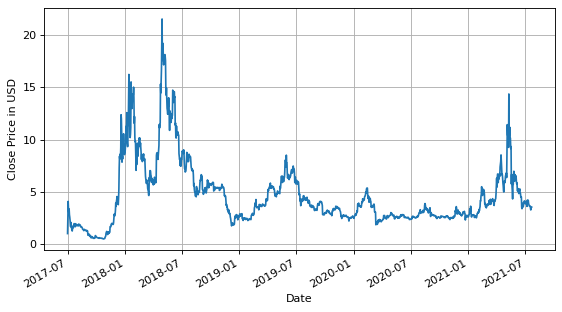

In [48]:
StopWatch.start("Overall time")

ticker = yf.Ticker("EOS-USD")
data = ticker.history(period = "15y", interval = "1d")

# Sort the dataframe according to the date
data.sort_values('Date', inplace=True, ascending=True)

# Print the dataframe top
data.head()

# Visualization of data. Plotting the price close.
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
data['Close'].plot()
plt.tight_layout()
plt.grid()
plt.ylabel('Close Price in USD')
plt.xlabel('Date')
plt.savefig(fullpath3, dpi=100, facecolor="#FFFFFF")
plt.show()

In [49]:
print(data.head())

                Open     High       Low    Close     Volume  Dividends  \
Date                                                                     
2017-07-01  1.031340  1.07176  0.989566  1.00669   13613000          0   
2017-07-02  0.996521  2.87751  0.822648  2.71005  320452000          0   
2017-07-03  2.717390  5.39597  2.632310  4.08664  414950016          0   
2017-07-04  4.098010  4.19124  2.933450  3.37200  218559008          0   
2017-07-05  3.356000  3.52350  2.730130  3.00323  124339000          0   

            Stock Splits  
Date                      
2017-07-01             0  
2017-07-02             0  
2017-07-03             0  
2017-07-04             0  
2017-07-05             0  


In [50]:
# Get Close data
df = data[['Close']].copy()
# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

print(len(train), len(test))

1279 200


In [51]:
train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [52]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

In [53]:
StopWatch.start("Training time")

model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)

StopWatch.stop("Training time")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40/40 [==============================] - 1s 7ms/step - loss: 0.0479

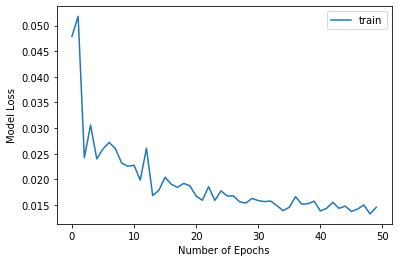

In [54]:
# Plotting the loss
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.show()

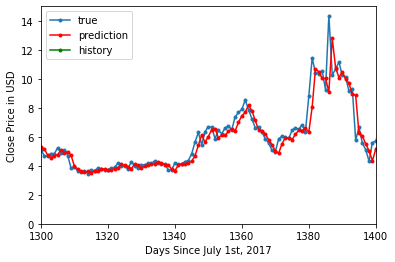

In [55]:
StopWatch.start("Prediction time")

y_pred = model.predict(X_test)

StopWatch.stop("Prediction time")

# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Close Price in USD')
plt.xlabel('Days Since July 1st, 2017')
plt.legend()
plt.savefig(fullpath, dpi=100, facecolor="#FFFFFF")
plt.axis([1300, 1400, 0, 15])
plt.savefig(fullpath2, dpi=100, facecolor="#FFFFFF")
plt.show()


In [56]:
print(y_test.shape)
print(y_pred.shape)


(190,)
(190, 1)


In [57]:
## Outputs error in United States Dollars
mean_squared_error(y_test, y_pred)

## Create a table of the error against the number of epochs

0.4577929532197626

In [58]:
StopWatch.stop("Overall time")
StopWatch.benchmark()


+------------------+--------------------------------------------------------------------------------+
| Attribute        | Value                                                                          |
|------------------+--------------------------------------------------------------------------------|
| cpu              |                                                                                |
| cpu_cores        | 6                                                                              |
| cpu_count        | 12                                                                             |
| cpu_threads      | 12                                                                             |
| frequency        | scpufreq(current=3600.0, min=0.0, max=3600.0)                                  |
| mem.available    | 1.9 GiB                                                                        |
| mem.free         | 1.9 GiB                                                     